# 1513 Final Assignment

### Ideas

*  covid outcome from air quality
*  air quality from income level
*  air quality from economic data
*  weather events and violence
*  natural gas prices and air quality


### Requirements
1. Choose a topic that interests you and define the ML/DL problem.
2. Source the dataset and explore the metadata (dataset information).
3. Explore and visualize the data before building the models.
4. Utilize Python’s libraries to train and validate your models.
5. Discuss your models practical use cases in your project summary.
6. Refer to the rubric in the next page for evaluation details.


Idea:

I recently came across this pocast regarding how the golden age of piracy (1850AD-1730AD) occured in tandem with fewer hurricanes, caused by cooler tempertures (caused by fluxiuations of the suns energy being released).

This co-occurance fascinated me, and since I have been curious wheither changes in temperature has played a role in other conflicts.

https://radiolab.org/podcast/fellowship-tree-rings
https://news.arizona.edu/story/shipwrecks-tree-rings-reveal-caribbean-hurricanes

The topic I will be looking at will be:
Can i build a model to predict global conflict from past global conflict data and global temperature data and will temperature features improve the models preformance.

Im not trying to predict future violence, so I do not feel compelled to treat this like a time series model. I'll be using temperature data from the current month as well as past violence and temperature data.

## War and Peace Data
EDA Goals:
* Explore how data is formatted
* find distance between first and last date
* Identify min and max of deaths per year
* Identify first and last year with data
* identify any missing years
* Evaluate data for potentially relevant features  

Data Processing:
* Reformat data so that each row is a different year

# Climate Data

EDA Goals:
* Identify min and max of temperature
* Identify first and last year with data
* Identify and missing data
* Identify data for potentially relevant features

# Data Professing:
Reformat data so each row is a different year

# Feature Engineering
* Join together two data sources
* Create data features dependent on the two types of data, and which depend on past data.
  * Temperature (I am comfortable using present year temp data to predict present year violence data)
    * change from previous year
  * Violence
    * Previous year violence


Importing Packages

In [ ]:
pip install torch

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


In [ ]:
import pandas as pd
import sklearn as sk
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import f1_score
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datetime import datetime, timedelta
import math as math
import torch


In [ ]:
!pwd

/content/drive/MyDrive


In [ ]:
violence_data = pd.read_csv("Colab Notebooks/ged171.csv")

In [ ]:
violence_data.shape

(135181, 42)

## Processing data

* removing unneeded columns


In [ ]:
violence_data = violence_data.drop(['low','high','deaths_unknown','deaths_a','deaths_b',
                    'deaths_civilians','date_prec','event_clarity','priogrid_gid',
                    'geom_wkt','adm_1','adm_2','latitude','longitude',
                    'source_headline','source_original','where_prec',
                    'where_coordinates','source_original','source_date',
                    'source_headline','dyad_new_id','dyad_name',
                    'side_a_new_id','gwnoa','side_a','side_b_new_id','gwnob',
                    'side_b','number_of_sources','source_article','source_office','id'],
                   axis = 1).rename(columns={"best": "deaths"}) # best is the best guess of the number of deaths

In [ ]:
violence_data.columns #checking the data because we have more columns than we needs

Index(['year', 'active_year', 'type_of_violence', 'conflict_new_id',
       'conflict_name', 'country', 'country_id', 'region', 'date_start',
       'date_end', 'deaths'],
      dtype='object')

In [ ]:
violence_data = violence_data[violence_data['deaths']> 0]
# we are keeping track of the death count over time, so we dont want conflict with no deaths

# Analysis of violence data
* average number of days of conflict

In [ ]:
violence_data['date_start'] = violence_data['date_start'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
violence_data['date_end'] = violence_data['date_end'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [ ]:
violence_data['lenght_of_violence'] = violence_data['date_end']-violence_data['date_start']
violence_data['lenght_of_violence']=violence_data['lenght_of_violence'].dt.days.astype('int16')

In [ ]:
print('max lenght: ' + str(violence_data['lenght_of_violence'].max()))
print('min length: ' + str(violence_data['lenght_of_violence'].min()))

max lenght: 365
min length: 0


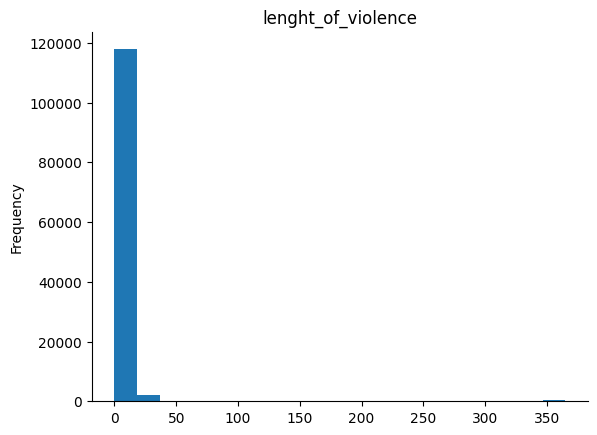

In [ ]:
from matplotlib import pyplot as plt
violence_data['lenght_of_violence'].astype(int).plot(kind='hist', bins=20, title='lenght_of_violence')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
print('occurance count, lenght above and below a day')
print(violence_data[violence_data['lenght_of_violence'].astype(int)==0].shape[0])
print(violence_data[violence_data['lenght_of_violence'].astype(int)>0].shape[0])

print('death count, lenght above and below a day')

print(violence_data[violence_data['lenght_of_violence']==0]['deaths'].sum())
print(violence_data[violence_data['lenght_of_violence']>0]['deaths'].sum())

occurance count, lenght above and below a day
99872
21785
death count, lenght above and below a day
917321
1041574


In [ ]:
print('occurance count, lenght above and below a month')
print(violence_data[violence_data['lenght_of_violence'].astype(int)<31].shape[0])
print(violence_data[violence_data['lenght_of_violence'].astype(int)>31].shape[0])

print('death count, lenght above and below a month')

print(violence_data[violence_data['lenght_of_violence'].astype(int)<31]['deaths'].sum())
print(violence_data[violence_data['lenght_of_violence'].astype(int)>31]['deaths'].sum())

occurance count, lenght above and below a month
119996
1626
death count, lenght above and below a month
1440779
514281


In [ ]:
print('occurance count, lenght above and below 3 months')
print(violence_data[violence_data['lenght_of_violence'].astype(int)<92].shape[0])
print(violence_data[violence_data['lenght_of_violence'].astype(int)>92].shape[0])

print('death count, lenght above and below 3 months')

print(violence_data[violence_data['lenght_of_violence'].astype(int)<91]['deaths'].sum())
print(violence_data[violence_data['lenght_of_violence'].astype(int)>=91]['deaths'].sum())

occurance count, lenght above and below 3 months
120624
1029
death count, lenght above and below 3 months
1808450
150445


In [ ]:
print('occurance count, lenght above and below a year')
print(violence_data[violence_data['lenght_of_violence'].astype(int)<365].shape[0])
print(violence_data[violence_data['lenght_of_violence'].astype(int)>=365].shape[0])

print('death count, lenght above and below a year')

print(violence_data[violence_data['lenght_of_violence'].astype(int)<365]['deaths'].sum())
print(violence_data[violence_data['lenght_of_violence'].astype(int)>=365]['deaths'].sum())

occurance count, lenght above and below a year
121552
105
death count, lenght above and below a year
1949786
9109


In [ ]:
violence_data[violence_data['lenght_of_violence']==violence_data['lenght_of_violence'].max()]

,year,active_year,type_of_violence,conflict_new_id,conflict_name,country,country_id,region,date_start,date_end,deaths,lenght_of_violence
4942,1992,1,3,480,Government of Sudan - Civilians,Sudan,625,Africa,1992-01-01,1992-12-31,200,365
4979,1992,1,3,480,Government of Sudan - Civilians,Sudan,625,Africa,1992-01-01,1992-12-31,15,365
5492,2004,1,2,4666,Ma'aliyah - Rizeigat Baggara,Sudan,625,Africa,2004-01-01,2004-12-31,1,365
5932,2004,0,2,4674,Misseriya - Rizeigat Abbala,Sudan,625,Africa,2004-01-01,2004-12-31,1,365
5990,2004,1,2,4666,Ma'aliyah - Rizeigat Baggara,Sudan,625,Africa,2004-01-01,2004-12-31,68,365
...,...,...,...,...,...,...,...,...,...,...,...,...
134495,2016,1,1,413,Ethiopia:Oromiya,Ethiopia,530,Africa,2016-01-01,2016-12-31,20,365
134496,2016,1,1,329,Ethiopia:Ogaden,Ethiopia,530,Africa,2016-01-01,2016-12-31,25,365
135167,2016,1,2,13737,Jalisco Cartel New Generation - Sinaloa Cartel,Mexico,70,Americas,2016-01-01,2016-12-31,83,365
135170,2016,1,2,13737,Jalisco Cartel New Generation - Sinaloa Cartel,Mexico,70,Americas,2016-01-01,2016-12-31,329,365


In [ ]:
print('max deaths: ' + str(violence_data['deaths'].max()))
print('min deaths: ' + str(violence_data['deaths'].min()))
# this is a really big range.  Im wondering if one is a one day conflict and the over is longer

max deaths: 300559
min deaths: 1


In [ ]:
violence_data[violence_data['deaths']==violence_data['deaths'].max()]

,year,active_year,type_of_violence,conflict_new_id,conflict_name,country,country_id,region,date_start,date_end,deaths,lenght_of_violence
28003,1994,1,3,472,Government of Rwanda - Civilians,Rwanda,517,Africa,1994-04-06,1994-07-04,300559,89


In [ ]:
violence_data[violence_data['conflict_new_id']==472]
# it looks like the one event with a very high death count covers basically the whole conflict which other enteries cover individual days.
# I need to decide which of the two types of data to get rid of, and how to identify that

,year,active_year,type_of_violence,conflict_new_id,conflict_name,country,country_id,region,date_start,date_end,deaths,lenght_of_violence
19669,1992,1,3,472,Government of Rwanda - Civilians,Rwanda,517,Africa,1992-07-01,1992-08-31,43,61
19674,1994,1,3,472,Government of Rwanda - Civilians,Rwanda,517,Africa,1994-04-07,1994-04-07,24,0
19676,2009,1,3,472,Government of Rwanda - Civilians,DR Congo (Zaire),490,Africa,2009-02-01,2009-02-28,2,27
19690,1994,1,3,472,Government of Rwanda - Civilians,Rwanda,517,Africa,1994-04-19,1994-04-19,60,0
19693,1992,1,3,472,Government of Rwanda - Civilians,Rwanda,517,Africa,1992-03-01,1992-05-31,36,91
...,...,...,...,...,...,...,...,...,...,...,...,...
130478,1994,1,3,472,Government of Rwanda - Civilians,Rwanda,517,Africa,1994-04-06,1994-04-08,3,2
130479,1994,1,3,472,Government of Rwanda - Civilians,Rwanda,517,Africa,1994-04-06,1994-04-08,3,2
130480,1994,1,3,472,Government of Rwanda - Civilians,Rwanda,517,Africa,1994-04-12,1994-04-14,3,2
130481,1994,1,3,472,Government of Rwanda - Civilians,Rwanda,517,Africa,1994-04-12,1994-04-14,3,2


In [ ]:
violence_data

,year,active_year,type_of_violence,conflict_new_id,conflict_name,country,country_id,region,date_start,date_end,deaths,lenght_of_violence
0,2010,1,1,230,Yemen (North Yemen):Government,Yemen (North Yemen),678,Middle East,2010-09-25,2010-09-25,2,0
3,2012,1,1,230,Yemen (North Yemen):Government,Yemen (North Yemen),678,Middle East,2012-06-04,2012-06-04,5,0
4,2012,1,1,230,Yemen (North Yemen):Government,Yemen (North Yemen),678,Middle East,2012-12-09,2012-12-09,5,0
7,1994,1,1,402,Yemen (North Yemen):South Yemen,Yemen (North Yemen),678,Middle East,1994-02-21,1994-02-24,10,3
9,2010,1,1,230,Yemen (North Yemen):Government,Yemen (North Yemen),678,Middle East,2010-06-12,2010-06-12,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
135165,2016,1,1,383,Turkey:Government,Turkey,640,Middle East,2016-07-15,2016-07-15,17,0
135166,2016,1,1,383,Turkey:Government,Turkey,640,Middle East,2016-07-16,2016-07-16,2,0
135167,2016,1,2,13737,Jalisco Cartel New Generation - Sinaloa Cartel,Mexico,70,Americas,2016-01-01,2016-12-31,83,365
135170,2016,1,2,13737,Jalisco Cartel New Generation - Sinaloa Cartel,Mexico,70,Americas,2016-01-01,2016-12-31,329,365


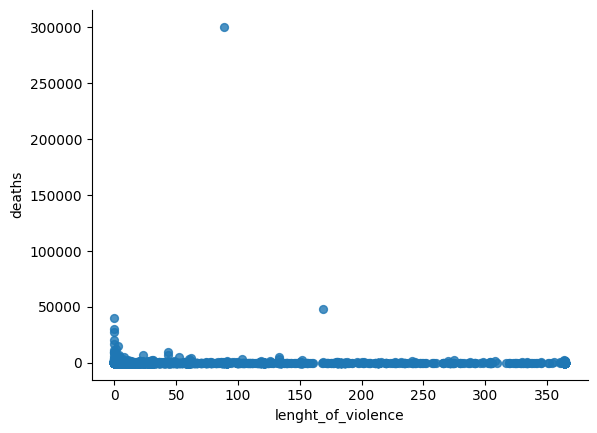

In [ ]:
from matplotlib import pyplot as plt
violence_data.plot(kind='scatter', x='lenght_of_violence', y='deaths', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Looking at the data, pull it apart by month, or any grouping other than year would likely take too long for this project.  
Im going to only work with data which begins and ends in the same month.

In [ ]:
violence_data[(violence_data['date_start'].dt.year == violence_data['date_end'].dt.year)]

,year,active_year,type_of_violence,conflict_new_id,conflict_name,country,country_id,region,date_start,date_end,deaths,lenght_of_violence
0,2010,1,1,230,Yemen (North Yemen):Government,Yemen (North Yemen),678,Middle East,2010-09-25,2010-09-25,2,0
3,2012,1,1,230,Yemen (North Yemen):Government,Yemen (North Yemen),678,Middle East,2012-06-04,2012-06-04,5,0
4,2012,1,1,230,Yemen (North Yemen):Government,Yemen (North Yemen),678,Middle East,2012-12-09,2012-12-09,5,0
7,1994,1,1,402,Yemen (North Yemen):South Yemen,Yemen (North Yemen),678,Middle East,1994-02-21,1994-02-24,10,3
9,2010,1,1,230,Yemen (North Yemen):Government,Yemen (North Yemen),678,Middle East,2010-06-12,2010-06-12,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
135165,2016,1,1,383,Turkey:Government,Turkey,640,Middle East,2016-07-15,2016-07-15,17,0
135166,2016,1,1,383,Turkey:Government,Turkey,640,Middle East,2016-07-16,2016-07-16,2,0
135167,2016,1,2,13737,Jalisco Cartel New Generation - Sinaloa Cartel,Mexico,70,Americas,2016-01-01,2016-12-31,83,365
135170,2016,1,2,13737,Jalisco Cartel New Generation - Sinaloa Cartel,Mexico,70,Americas,2016-01-01,2016-12-31,329,365


In [ ]:
vd_sample = violence_data[(violence_data['date_start'].dt.year == violence_data['date_end'].dt.year)&(violence_data['date_start'].dt.month == violence_data['date_end'].dt.month)]

In [ ]:
vd_sample['year_month']= vd_sample['date_start'].apply(lambda x: x.replace(day=6))

<ipython-input-19-32a0b7bb1c15>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vd_sample['year_month']= vd_sample['date_start'].apply(lambda x: x.replace(day=6))


In [ ]:
(vd_sample['deaths'].sum())/(violence_data['deaths'].sum()) # were keeping about 70% of the data

0.6982084287315042

In [ ]:
vd_sample.shape

(118720, 13)

In [ ]:
print(vd_sample['year_month'].min())
print(vd_sample['year_month'].max())

1989-01-06 00:00:00
2016-12-06 00:00:00


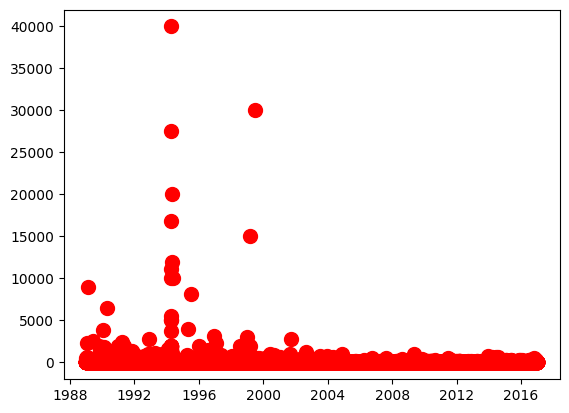

In [ ]:
plt.scatter(vd_sample['date_start'], vd_sample['deaths'], s =100, c = 'red')

## Weather Data

* validate the data covers every month and covers the same time line as the death data

https://datahub.io/collections/climate-data


In [ ]:
df = pd.read_csv('Colab Notebooks/monthly_csv.csv')
temp = df.set_index(['Date','Source'])['Mean']\
  .unstack()\
  .add_prefix('Mean_')\
  .rename_axis([None], axis=1)\
  .reset_index()
temp['Date'] = temp['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [ ]:
temp # all the data is recordered relative to preindustrial levels for each month

,Date,Mean_GCAG,Mean_GISTEMP
0,1880-01-06,0.0009,-0.30
1,1880-02-06,-0.1229,-0.21
2,1880-03-06,-0.1357,-0.18
3,1880-04-06,-0.0499,-0.27
4,1880-05-06,-0.0738,-0.14
...,...,...,...
1639,2016-08-06,0.8998,0.98
1640,2016-09-06,0.8767,0.87
1641,2016-10-06,0.7292,0.89
1642,2016-11-06,0.7504,0.93


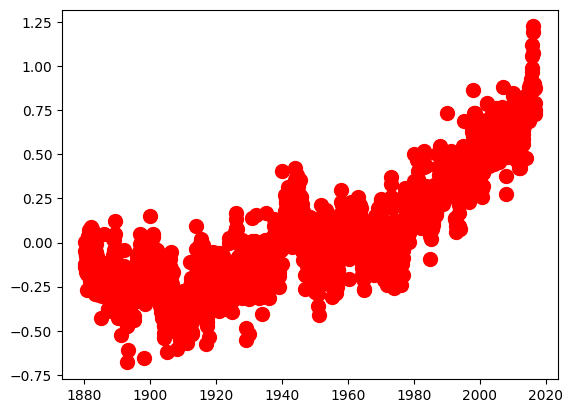

In [ ]:
plt.scatter(temp['Date'], temp['Mean_GCAG'], s =100, c = 'red') # this is just land
# we can see climate change in here

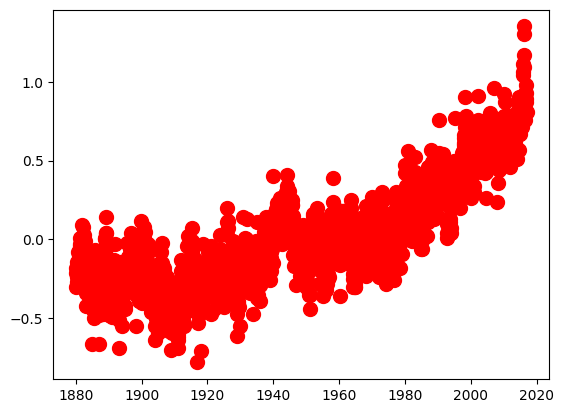

In [ ]:
plt.scatter(temp['Date'], temp['Mean_GISTEMP'], s =100, c = 'red') # this is land and ocean

# Joining the data together

In [ ]:
data_together = pd.merge(vd_sample, temp, left_on='year_month',right_on='Date',how='right')
data_together = data_together[(data_together['Date']>(vd_sample['year_month'].min()-timedelta(days=396)))&((data_together['Date']<=vd_sample['year_month'].max()))].sort_values('Date')

In [ ]:
data_together

,year,active_year,type_of_violence,conflict_new_id,conflict_name,country,country_id,region,date_start,date_end,deaths,lenght_of_violence,year_month,Date,Mean_GCAG,Mean_GISTEMP
1296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,1988-01-06,0.5487,0.57
1297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,1988-02-06,0.3901,0.42
1298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,1988-03-06,0.4828,0.49
1299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,1988-04-06,0.4426,0.45
1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,1988-05-06,0.3811,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119777,2016.0,1.0,1.0,259.0,Iraq:Government,Iraq,645.0,Middle East,2016-12-22,2016-12-22,26.0,0.0,2016-12-06,2016-12-06,0.7895,0.81
119776,2016.0,1.0,1.0,259.0,Iraq:Government,Iraq,645.0,Middle East,2016-12-20,2016-12-21,8.0,1.0,2016-12-06,2016-12-06,0.7895,0.81
119775,2016.0,1.0,1.0,259.0,Iraq:Government,Iraq,645.0,Middle East,2016-12-20,2016-12-20,3.0,0.0,2016-12-06,2016-12-06,0.7895,0.81
119784,2016.0,1.0,1.0,333.0,Afghanistan:Government,Afghanistan,700.0,Asia,2016-12-25,2016-12-25,1.0,0.0,2016-12-06,2016-12-06,0.7895,0.81


In [ ]:
monthly_data = data_together.groupby(['Date','Mean_GCAG', 'Mean_GISTEMP'])['deaths'].sum().to_frame().reset_index()
#this is now a quite small dataset. I thought i had more climate date.  This might not be enough
monthly_data

,Date,Mean_GCAG,Mean_GISTEMP,deaths
0,1988-01-06,0.5487,0.57,0.0
1,1988-02-06,0.3901,0.42,0.0
2,1988-03-06,0.4828,0.49,0.0
3,1988-04-06,0.4426,0.45,0.0
4,1988-05-06,0.3811,0.44,0.0
...,...,...,...,...
343,2016-08-06,0.8998,0.98,4594.0
344,2016-09-06,0.8767,0.87,3068.0
345,2016-10-06,0.7292,0.89,6316.0
346,2016-11-06,0.7504,0.93,3366.0


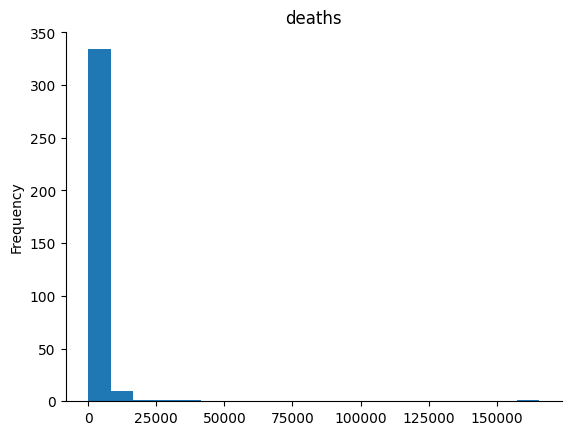

In [ ]:
from matplotlib import pyplot as plt
monthly_data['deaths'].plot(kind='hist', bins=20, title='deaths')
plt.gca().spines[['top', 'right',]].set_visible(False)

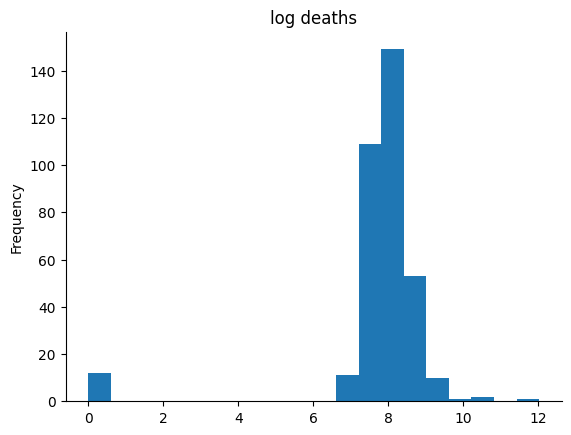

In [ ]:
from matplotlib import pyplot as plt
np.log(monthly_data['deaths']+1).plot(kind='hist', bins=20, title='log deaths')
plt.gca().spines[['top', 'right',]].set_visible(False)


applying the log function to the distributions of deaths makes the distribution much more normal. I will use the log of deaths as my target feature.

In [ ]:
x = np.array([x.year for x in monthly_data['Date']])
unique, counts = np.unique(x, return_counts=True)

print(np.asarray((unique, counts)))
# no months are missing other than the first month of 1989 and the last month of 2016.  This is fine.

[[1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
  2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
  2016]
 [  12   12   12   12   12   12   12   12   12   12   12   12   12   12
    12   12   12   12   12   12   12   12   12   12   12   12   12   12
    12]]


In [ ]:
monthly_data['month']=monthly_data['Date'].apply(lambda x: x.month)

Text(0, 0.5, 'GISTEMP')

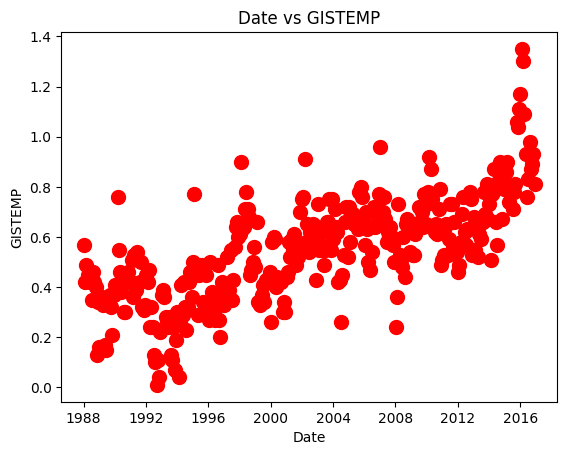

In [ ]:
plt.scatter(monthly_data['Date'], monthly_data['Mean_GISTEMP'], s =100, c = 'red') # this is land and ocean
plt.title('Date vs GISTEMP')
plt.xlabel("Date")
plt.ylabel("GISTEMP")

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Log Deaths')

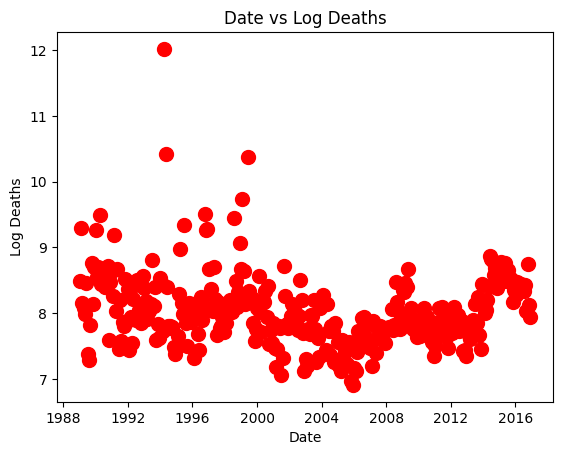

In [ ]:
plt.scatter(monthly_data['Date'], np.log(monthly_data['deaths']), s =100, c = 'red')
plt.title('Date vs Log Deaths')
plt.xlabel("Date")
plt.ylabel("Log Deaths")

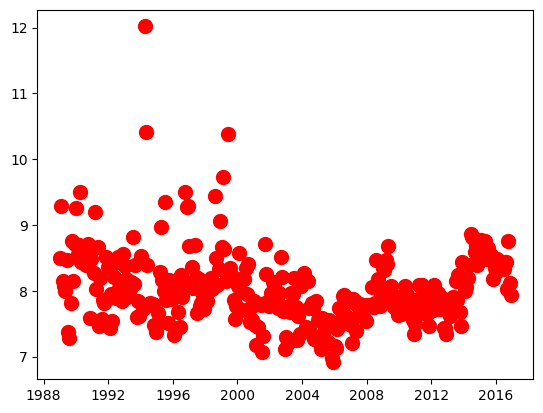

In [ ]:
plt.scatter(monthly_data['Date'], np.log(monthly_data['deaths']), s =100, c = 'red') # no clear trend

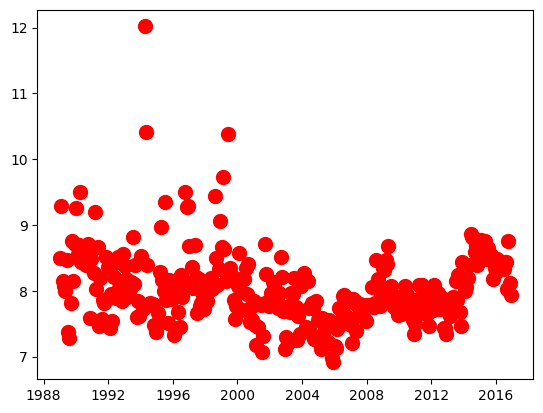

In [ ]:
plt.scatter(monthly_data['Date'], np.log(monthly_data['deaths']), s =100, c = 'red') # no clear trend

In [ ]:
monthly_data

,Date,Mean_GCAG,Mean_GISTEMP,deaths,month
0,1988-01-06,0.5487,0.57,0.0,1
1,1988-02-06,0.3901,0.42,0.0,2
2,1988-03-06,0.4828,0.49,0.0,3
3,1988-04-06,0.4426,0.45,0.0,4
4,1988-05-06,0.3811,0.44,0.0,5
...,...,...,...,...,...
343,2016-08-06,0.8998,0.98,4594.0,8
344,2016-09-06,0.8767,0.87,3068.0,9
345,2016-10-06,0.7292,0.89,6316.0,10
346,2016-11-06,0.7504,0.93,3366.0,11


In [ ]:
monthly_data['month-1_deaths'] = monthly_data['deaths'].shift(1)
monthly_data['month-2_deaths'] = monthly_data['deaths'].shift(2)
monthly_data['month-3_deaths'] = monthly_data['deaths'].shift(3)
monthly_data['year-1_deaths'] = monthly_data['deaths'].shift(12)
monthly_data['month-1_diff_Mean_GISTEMP'] = monthly_data['Mean_GISTEMP']-monthly_data['Mean_GISTEMP'].shift(1)
monthly_data['year-1_diff_Mean_GISTEMP'] = monthly_data['Mean_GISTEMP']-monthly_data['Mean_GISTEMP'].shift(12)
monthly_data['month-1_diff_Mean_GCAG'] = monthly_data['Mean_GISTEMP']-monthly_data['Mean_GCAG'].shift(1)
monthly_data['year-1_diff_Mean_GCAG'] = monthly_data['Mean_GISTEMP']-monthly_data['Mean_GCAG'].shift(12)

In [ ]:
monthly_data=monthly_data[monthly_data['Date']>=vd_sample['year_month'].min()]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(monthly_data.drop(['deaths','Date'],axis=1),
                                                    monthly_data['deaths'], test_size=0.2, shuffle=False)

#were taking the log of all the death counts to make it more normally distributed without losing interpretability from using the normalizer function.
# this will change th values of our

# Scaling and Normalizing Data

Because this is a regression problem and ill likely be using gradient descent, I should scale the target value along with other values.  

You apply normalization and scaling after splitting data.  But I'm to take those scales from the train set and apply them to the test set as well.

In [ ]:
X_train.describe()


,Mean_GCAG,Mean_GISTEMP,month,month-1_deaths,month-2_deaths,month-3_deaths,year-1_deaths,month-1_diff_Mean_GISTEMP,year-1_diff_Mean_GISTEMP,month-1_diff_Mean_GCAG,year-1_diff_Mean_GCAG
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,0.497414,0.498657,6.440299,4152.141791,4142.373134,4134.376866,4056.458955,0.001157,0.010075,0.002323,0.012588
std,0.160900,0.179150,3.469527,10447.922208,10450.585538,10452.940682,10474.447392,0.124406,0.194035,0.116450,0.180681
min,0.058800,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.330000,-0.720000,-0.333300,-0.643900
25%,0.383475,0.370000,3.000000,2139.750000,2128.500000,2119.250000,2043.750000,-0.080000,-0.110000,-0.068375,-0.098075
50%,0.503050,0.500000,6.000000,2690.500000,2690.500000,2690.500000,2667.000000,0.000000,0.010000,0.008400,0.008700
75%,0.622950,0.640000,9.000000,3703.250000,3703.250000,3703.250000,3703.250000,0.080000,0.130000,0.073900,0.127625
max,0.883900,0.960000,12.000000,165566.000000,165566.000000,165566.000000,165566.000000,0.370000,0.730000,0.352800,0.690900


In [ ]:
X_train_no_weather = X_train[['month', 'month-1_deaths','month-2_deaths', 'month-3_deaths', 'year-1_deaths']]
X_test_no_weather = X_test[['month', 'month-1_deaths','month-2_deaths', 'month-3_deaths', 'year-1_deaths']]

In [ ]:
y_train.describe()

count       268.000000
mean       4164.235075
std       10444.973462
min        1004.000000
25%        2164.750000
50%        2701.500000
75%        3703.250000
max      165566.000000
Name: deaths, dtype: float64

In [ ]:
scaler = StandardScaler()
normalizer = Normalizer()
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_train_scale = pd.DataFrame((normalizer.fit_transform((X_train_scale.values).T)).T, columns=X_train_scale.columns, index=X_train_scale.index)

# using the same scaling and normalizer for test data, but without transform.  No data leakage while keeping the transformation the same
X_test_scale = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns, index=X_test.index)
X_test_scale = pd.DataFrame((normalizer.fit_transform((X_test_scale.values).T)).T, columns=X_test_scale.columns, index=X_test_scale.index)

X_train_no_weather_scale = pd.DataFrame(scaler.fit_transform(X_train_no_weather.values), columns=X_train_no_weather.columns, index=X_train_no_weather.index)
X_train_no_weather_norm_scale = pd.DataFrame((normalizer.fit_transform((X_train_no_weather_scale.values).T)).T, columns=X_train_no_weather_scale.columns, index=X_train_no_weather_scale.index)

# using the same scaling and normalizer for test data, but without transform.  No data leakage while keeping the transformation the same
X_test_no_weather_scale = pd.DataFrame(scaler.transform(X_test_no_weather.values), columns=X_test_no_weather.columns, index=X_test_no_weather.index)
X_test_no_weather_norm_scale = pd.DataFrame((normalizer.fit_transform((X_test_no_weather_scale.values).T)).T, columns=X_test_no_weather_scale.columns, index=X_test_no_weather_scale.index)


# scaling target value too
# this is so we dont get an exploding gradient for models with GD
max = np.log(y_train.max()+1)
min = np.log(y_train.min()+1)
y_train_scaled = (np.log(y_train+1)-min)/(max-min)
y_test_scaled = (np.log(y_test+1)-min)/(max-min)

#inverse will be pred_y = np.exp(pred*(max-min)+min)-1

In [ ]:
def log_normalize_target(target):
  target[target < 0] = 0
  target_scaled =(np.log(target+1)-min)/(max-min)
  return target_scaled

def inverse_log_normalize_target(pred):
  pred_y = np.exp(pred*(max-min)+min)-1
  return pred_y

Creating Functions to evaluate classical models

In [ ]:
def model_eval_log_target(model, X_train_scale,X_test_scale,y_train_scaled,y_test_scaled, y_train=y_train,y_test=y_test):
  model.fit(X_train_scale, y_train_scaled)
  pred_test = model.predict(X_test_scale)
  pred_train = model.predict(X_train_scale)
  print("train MSE: "+str(sk.metrics.mean_squared_error(pred_train,y_train_scaled))) #SME
  print("train RMSE: "+str(math.sqrt(sk.metrics.mean_squared_error(pred_train,y_train_scaled)) )) #RMSE
  print("true (unscaled and unnormalized) train RMSE: "+ str(math.sqrt(sk.metrics.mean_squared_error(inverse_log_normalize_target(pred_train),y_train)) ))
  print("test MSE: "+str(sk.metrics.mean_squared_error(pred_test,y_test_scaled))) #SME
  print("test RMSE: "+str(math.sqrt(sk.metrics.mean_squared_error(pred_test,y_test_scaled)) )) #RMSE
  print("true (unscaled and unnormalized) test RMSE: "+ str(math.sqrt(sk.metrics.mean_squared_error(inverse_log_normalize_target(pred_test),y_test)) ))

  f, (ax1,ax2) = plt.subplots(1,2)
  ax1.title.set_text('log of target vs predicted ')
  ax1.scatter(y_test_scaled, pred_test, c='b') # plotting t, b separately
  ax1.plot(np.array([0,y_test_scaled.max()]),np.array([0,y_test_scaled.max()]))
  ax1.set_xlabel("scaled target value")
  ax1.set_ylabel("predicted value")
  ax2.title.set_text('target vs inverse log predicted')
  ax2.scatter(y_test, inverse_log_normalize_target(pred_test), c='b') # plotting t, b separately
  ax2.plot(np.array([0,y_test.max()]),np.array([0,y_test.max()]))
  ax2.set_xlabel("target value")
  ax2.set_ylabel("unscaled predicted value")
  plt.show()
  return model

def model_eval_target(model, X_train_scale=X_train_scale,X_test_scale=X_test_scale,y_train_scaled=y_train_scaled,y_test_scaled=y_test_scaled, y_train=y_train,y_test=y_test):
  model.fit(X_train_scale, y_train)
  pred_test = model.predict(X_test_scale)
  pred_train = model.predict(X_train_scale)
  print("train MSE: "+str(sk.metrics.mean_squared_error(pred_train,y_train))) #SME
  print("train RMSE: "+str(math.sqrt(sk.metrics.mean_squared_error(pred_train,y_train)) )) #RMSE
  print("log scaled train RMSE: "+ str(math.sqrt(sk.metrics.mean_squared_error(log_normalize_target(pred_train),y_train_scaled))))
  print("test MSE: "+str(sk.metrics.mean_squared_error(pred_test,y_test_scaled))) #SME
  print("test RMSE: "+str(math.sqrt(sk.metrics.mean_squared_error(pred_test,y_test_scaled)) )) #RMSE
  print("log scaled test RMSE: "+ str(math.sqrt(sk.metrics.mean_squared_error(log_normalize_target(pred_test),y_test_scaled)) ))

  f, (ax1,ax2) = plt.subplots(1,2)
  ax1.title.set_text('log of target vs log predicted')
  ax1.scatter(y_test_scaled, log_normalize_target(pred_test), c='b') # plotting t, b separately
  ax1.plot(np.array([0,y_test_scaled.max()]),np.array([0,y_test_scaled.max()]))
  ax1.set_xlabel("scaled target value")
  ax1.set_ylabel("scaled predicted value")
  ax2.title.set_text('target vs predicted')
  ax2.scatter(y_test, pred_test, c='b') # plotting t, b separately
  ax2.plot(np.array([0,y_test.max()]),np.array([0,y_test.max()]))
  ax2.set_xlabel("target value")
  ax2.set_ylabel("predicted value")
  plt.show()
  return model

# Baseline Linear Regression Model

train MSE: 101413117.03763935
train RMSE: 10070.40798764575
log scaled train RMSE: 0.2676508581260554
test MSE: 27915203.305307455
test RMSE: 5283.484012023454
log scaled test RMSE: 0.9903031469133525


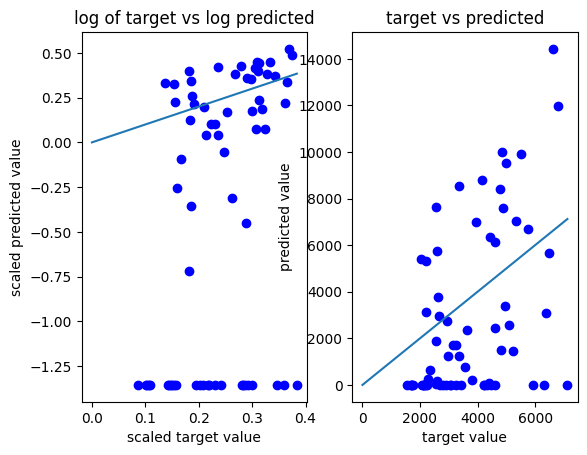

LinearRegression()

In [ ]:
LR = sk.linear_model.LinearRegression()
model_eval_target(LR, X_train_scale,X_test_scale,y_train_scaled,y_test_scaled)

train MSE: 104900554.64766465
train RMSE: 10242.09718015137
log scaled train RMSE: 0.11929403188174544
test MSE: 23025203.67613303
test RMSE: 4798.458468730664
log scaled test RMSE: 0.7808540608595299


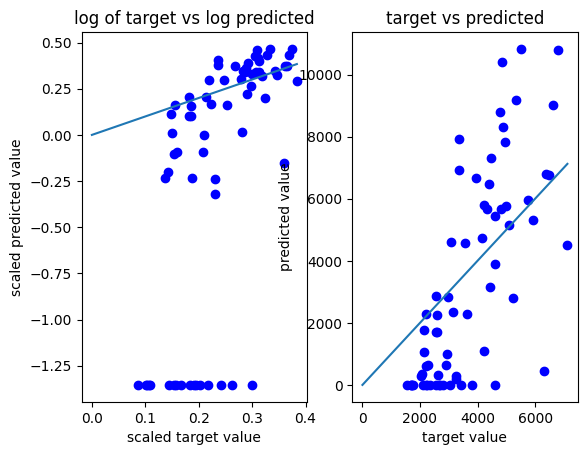

LinearRegression()

In [ ]:
LR = sk.linear_model.LinearRegression()
model_eval_target(LR, X_train_no_weather_norm_scale,X_test_no_weather_norm_scale,y_train_scaled,y_test_scaled)

In [ ]:
# this model does a very bad job
# the only violence data does a worse job

# Random Forest Regression

right off the bat this model is performing better than linear regression with grid search

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


train MSE: 16369667.60260082
train RMSE: 4045.944587188611
log scaled train RMSE: 11226.219646103013
test MSE: 4582084.306784256
test RMSE: 2140.5803668127614
log scaled test RMSE: 3978.289126646978


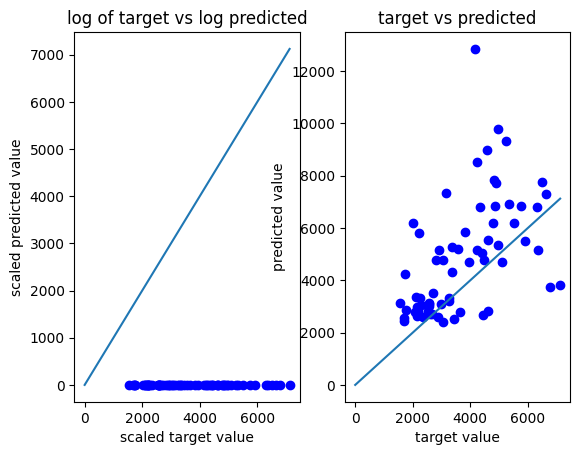

In [ ]:
RFR = RandomForestRegressor()
forest_params = [{'max_depth': list(range(1, 15,5)), 'max_features': list(range(1,X_train_scale.shape[1],3))}]
clf = GridSearchCV(RFR, forest_params, cv = 10, scoring='neg_mean_squared_error')
rfr = model_eval_target(clf, X_train_scale,X_test_scale,y_train,y_test)

train MSE: 0.0030288913996998185
train RMSE: 0.055035364991065684
true (unscaled and unnormalized) train RMSE: 6723.940032691965
test MSE: 0.002828719801811856
test RMSE: 0.05318571050396766
true (unscaled and unnormalized) test RMSE: 1021.5623005364786


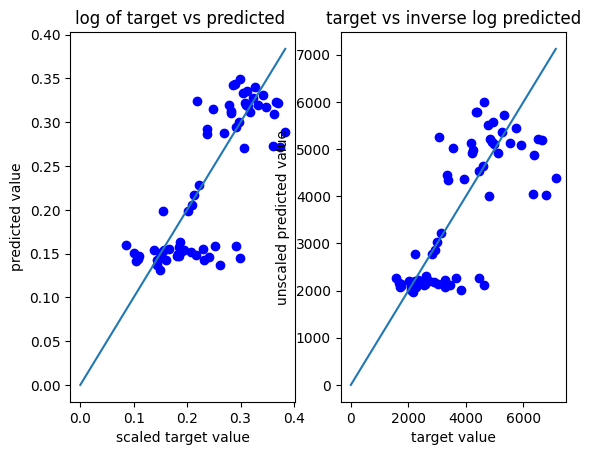

In [ ]:
RFR = RandomForestRegressor()
forest_params = [{'max_depth': list(range(1, 15,5)), 'max_features': list(range(1,X_train_scale.shape[1],3))}]
clf = GridSearchCV(RFR, forest_params, cv = 10, scoring='neg_mean_squared_error')
rfr = model_eval_log_target(clf, X_train_scale,X_test_scale,y_train_scaled,y_test_scaled)

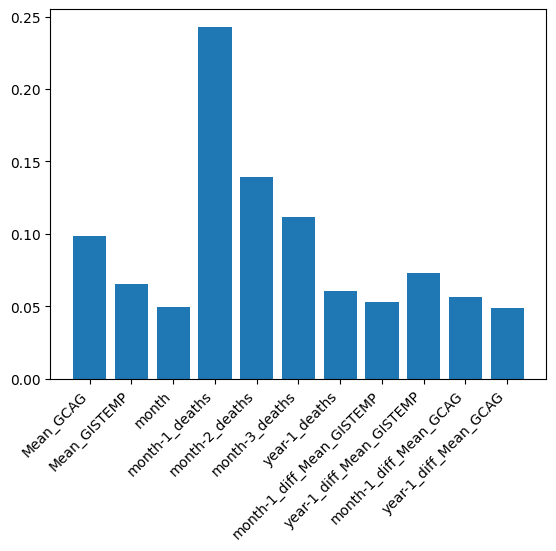

In [ ]:
plt.bar(x=X_train.columns,height=rfr.best_estimator_.feature_importances_)
plt.xticks(rotation=45, ha='right')
plt.show()

train MSE: 104205547.98832247
train RMSE: 10208.111871855757
log scaled train RMSE: 11226.251953820587
test MSE: 2127578.2362048277
test RMSE: 1458.622033360537
log scaled test RMSE: 3978.287023664404


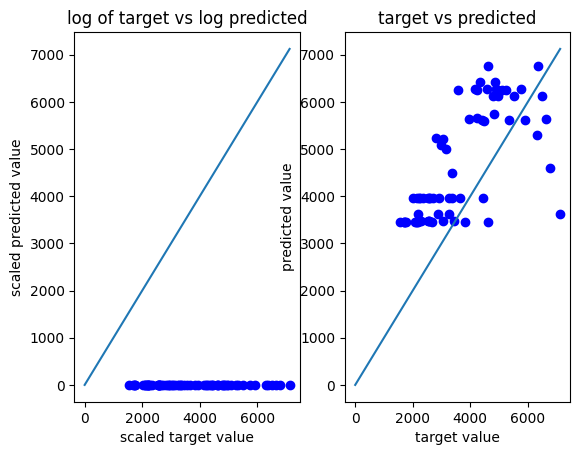

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [1, 6, 11],
                          'max_features': [1, 4, 7, 10]}],
             scoring='neg_mean_squared_error')

In [ ]:
RFR = RandomForestRegressor()
forest_params = [{'max_depth': list(range(1, 15,5)), 'max_features': list(range(1,X_train_scale.shape[1],3))}]
clf = GridSearchCV(RFR, forest_params, cv = 10, scoring='neg_mean_squared_error')
model_eval_target(clf, X_train_no_weather_norm_scale,X_test_no_weather_norm_scale,y_train,y_test)

train MSE: 0.004294196348898638
train RMSE: 0.06553011787642869
true (unscaled and unnormalized) train RMSE: 8737.731845176175
test MSE: 0.004429499578981681
test RMSE: 0.06655448579158042
true (unscaled and unnormalized) test RMSE: 1198.1075418591636


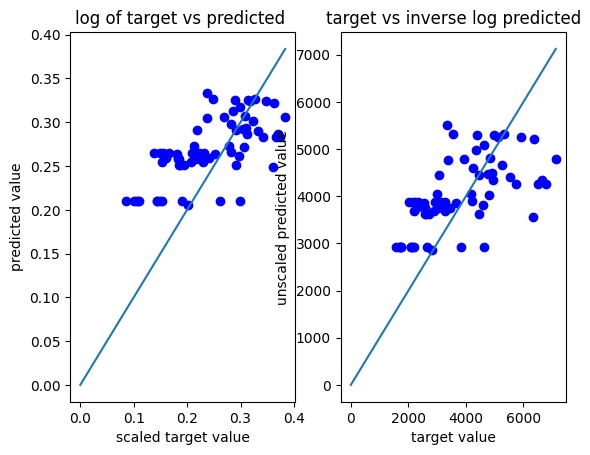

In [ ]:
RFR = RandomForestRegressor()
forest_params = [{'max_depth': list(range(1, 15,5)), 'max_features': list(range(1,X_train_scale.shape[1],3))}]
clf = GridSearchCV(RFR, forest_params, cv = 10, scoring='neg_mean_squared_error')
clf = model_eval_log_target(clf, X_train_no_weather_norm_scale,X_test_no_weather_norm_scale,y_train_scaled,y_test_scaled)

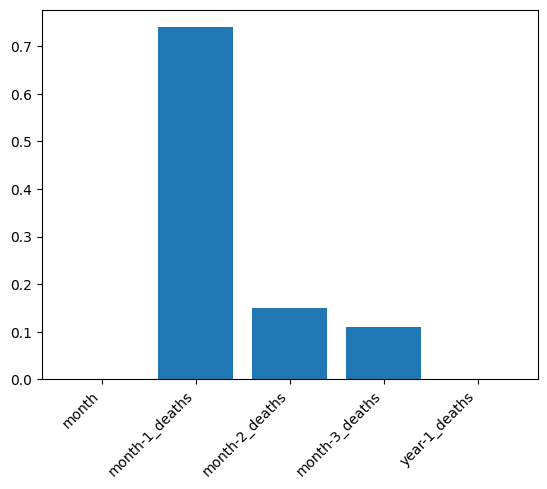

In [ ]:
plt.bar(x=X_train_no_weather_norm_scale.columns,height=clf.best_estimator_.feature_importances_)
plt.xticks(rotation=45, ha='right')
plt.show()

When I apply the log scaling of the target value, then train the model, the results are better.

In [ ]:
#the model seems to do an OK job unless the true values are high.
# the MSE and RMSE are both lower than the baseline linear regression model
# the model does not appear overfit.  if fact it performs better on the test data.

# Support vector Machine Regression

train MSE: 110798378.78643286
train RMSE: 10526.080884471336
log scaled train RMSE: 0.11554516833089958
test MSE: 7317201.47653179
test RMSE: 2705.032620234327
log scaled test RMSE: 0.09096496130286998


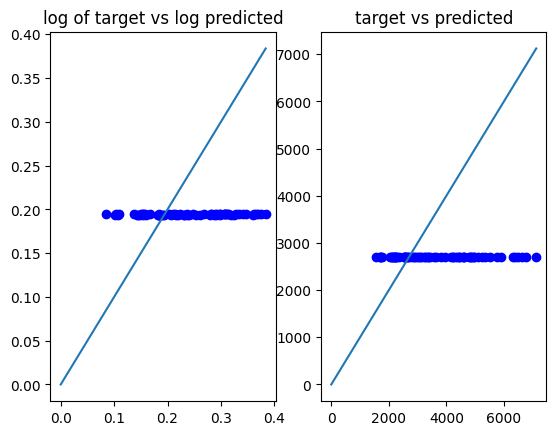

SVR()

In [ ]:
SVR= sk.svm.SVR()
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
clf = GridSearchCV(RFR, forest_params, cv = 10, scoring='neg_mean_squared_error')
model_eval_target(SVR, X_train_scale,X_test_scale,y_train_scaled,y_test_scaled)


train MSE: 0.007401515805745564
train RMSE: 0.08603206266122859
true (unscaled and unnormalized) train RMSE: 10103.619334106894
test MSE: 0.00534568079746267
test RMSE: 0.07311416276934771
true (unscaled and unnormalized) test RMSE: 1296.8140058338706


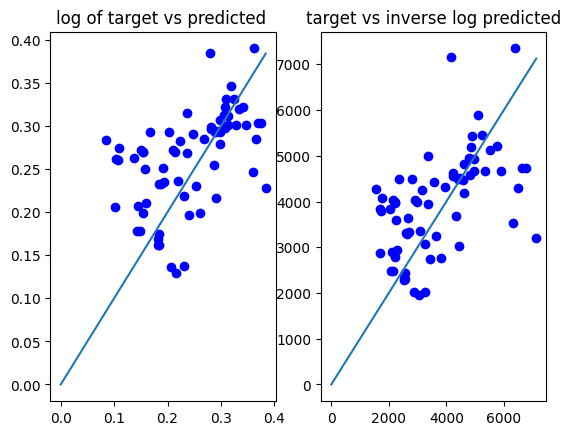

SVR()

In [ ]:
SVR= sk.svm.SVR()
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
clf = GridSearchCV(RFR, forest_params, cv = 10, scoring='neg_mean_squared_error')
model_eval_log_target(SVR, X_train_scale,X_test_scale,y_train_scaled,y_test_scaled)


train MSE: 0.010157895889351305
train RMSE: 0.10078638742087795
true (unscaled and unnormalized) train RMSE: 10435.516555644017
test MSE: 0.003337848877564916
test RMSE: 0.05777411944430582
true (unscaled and unnormalized) test RMSE: 1172.7043851128099


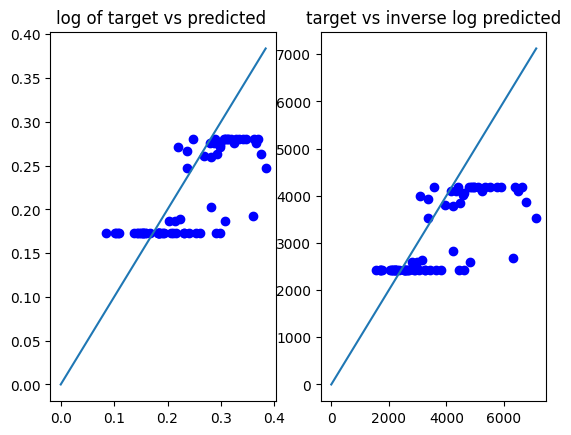

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [1, 6, 11],
                          'max_features': [1, 4, 7, 10]}],
             scoring='neg_mean_squared_error')

In [ ]:
SVR= sk.svm.SVR()
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
clf = GridSearchCV(RFR, forest_params, cv = 10, scoring='neg_mean_squared_error')
model_eval_log_target(clf, X_train_no_weather_norm_scale,X_test_no_weather_norm_scale,y_train_scaled,y_test_scaled)

In [ ]:
# this model is worse than the random forest but better than the baseline model

# Neural Network
creating NN and defining functions to evaluate performance

In [ ]:
class Model(torch.nn.Module):
    def __init__(self,parameter_dict):
        super().__init__()

        #TO DO
        #initial_embedding = torch.rand(embedding_size, vocab_size)
        self.parameter_dict= parameter_dict
        self.relu = torch.nn.ReLU()
        for x in range(len(parameter_dict['layers_output_size'])):
          if x==0:
            insize = parameters_dict['in_features']
          else: insize = outsize
          if x==len(parameter_dict['layers_output_size'])-1:
            outsize = 1
          else:
            outsize = parameter_dict['layers_output_size'][x]
          exec("self.layer_"+ str(x) + " = torch.nn.Linear(in_features=insize,out_features=outsize)")

    def forward(self, x):
        """
        x: torch.tensor of shape (bsz), bsz is the batch size
        """
        for i in range(len(self.parameter_dict['layers_output_size'])):
          x = self.relu(x)
          x = eval('self.layer_'+str(i)+'(x)')
        relu_output = self.relu(x)
        return relu_output

In [ ]:

def final_preds(dataloader, network):
  final_results = np.empty([0])
  for batch, (X,y) in enumerate(dataloader):
    results = network(X).detach().squeeze(1).numpy()
    final_results= np.append(final_results,results,axis=0)
  return final_results

def model_test_or_validate(dataloader, network,loss_fn):
  se_s = 0
  losses =0
  lens = 0
  for batch, (X,y) in enumerate(dataloader):
    relu_results = network(X)
    loss = loss_fn(relu_results, y.float().unsqueeze(1)) #loss is MSE
    losses += loss*y.size(0)
    lens += y.size(0)
  rmse = math.sqrt(float(losses/lens))
  return float(losses/lens), rmse


def train_model(train_dataloader, test_dataloader, parameter_dict, make_plots=True):
    # Set up a model with Skip-gram (predict context with word)
    # textlist: a list of the strings

    # Create the training data

    epochs = parameter_dict['epochs']

    # instantiate the network & set up the optimizer
    # TO DO

    network = Model(parameter_dict)
    network.train()
    loss_fn = torch.nn.MSELoss()
    learning_rate=parameter_dict['learning_rate']
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

    train_loss = []
    test_loss  = []
    train_RMSE = []
    test_RMSE = []

    if parameter_dict['scheduler']:
      scheduler =  lr_scheduler.LinearLR(optimizer, start_factor=learning_rate, end_factor=learning_rate*1e-5, total_iters=parameters_dict['epochs'])# tried both exponential and linear LR scheduling
      #lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)

    for epoch in range(epochs):
      epoch_loss = 0
      epoch_count = 0
      epoch_accuracy = 0
      epoch_f1 = 0
      for batch, (X,y) in enumerate(train_dataloader):
          optimizer.zero_grad()
          #Compute prediction and loss
          relu_results = network(X) # this returns the matrix logits, and the softmax of the batch
          loss = loss_fn(relu_results,
                        y.float().unsqueeze(1))  # loss function of only the output logits options and the actual values

          # Backpropagation
          loss.backward()
          optimizer.step()

          epoch_loss += loss * y.size(0)
          epoch_count += y.size(0)
      if parameter_dict['scheduler']:
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]

      #train results
      train_loss.append(float(epoch_loss/epoch_count))
      train_RMSE.append(math.sqrt(float(epoch_loss/epoch_count)))

      tl, tr = model_test_or_validate(test_dataloader, network, loss_fn)
      test_loss.append(tl)
      test_RMSE.append(tr)
    final_results = final_preds(test_dataloader, network)


    if make_plots == True:
      # plot lines
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.plot(range(epochs), train_loss, label = "train MSE")
      ax1.plot(range(epochs), test_loss, label = "test MSE")
      ax1.legend()

      ax2.plot(range(epochs), train_RMSE, label = "train RMSE")
      ax2.plot(range(epochs), test_RMSE, label = "test RMSE")
      ax2.legend()


    plt.show()
    print('final MSE: '+str(test_loss[-1]))
    print('final RMSE: '+str(test_RMSE[-1]))
    return network, test_RMSE, final_results

In [ ]:
def eval_log_target(pred_test, X_train=X_train,X_test=X_test,y_train_scaled=y_train_scaled,y_test_scaled=y_test_scaled, y_train=y_train,y_test=y_test):
  print("test MSE: "+str(sk.metrics.mean_squared_error(pred_test,y_test_scaled))) #SME
  print("test RMSE: "+str(math.sqrt(sk.metrics.mean_squared_error(pred_test,y_test_scaled)) )) #RMSE
  print("true (unscaled and unnormalized) test RMSE: "+ str(math.sqrt(sk.metrics.mean_squared_error(inverse_log_normalize_target(pred_test),y_test)) ))

  f, (ax1,ax2) = plt.subplots(1,2)
  ax1.title.set_text('log of target vs predicted ')
  ax1.scatter(y_test_scaled, pred_test, c='b') # plotting t, b separately
  ax1.plot(np.array([0,y_test_scaled.max()]),np.array([0,y_test_scaled.max()]))
  ax2.title.set_text('target vs inverse log predicted')
  ax2.scatter(y_test, inverse_log_normalize_target(pred_test), c='b') # plotting t, b separately
  ax2.plot(np.array([0,y_test.max()]),np.array([0,y_test.max()]))
  plt.show()
  return model
def eval_target(pred_test, X_train=X_train,X_test=X_test,y_train_scaled=y_train_scaled,y_test_scaled=y_test_scaled, y_train=y_train,y_test=y_test):
  print("test MSE: "+str(sk.metrics.mean_squared_error(pred_test,y_test))) #SME
  print("test RMSE: "+str(math.sqrt(sk.metrics.mean_squared_error(pred_test,y_test)) )) #RMSE
  print("log scaled test RMSE: "+ str(math.sqrt(sk.metrics.mean_squared_error(log_normalize_target(pred_test),y_test_scaled)) ))

  f, (ax1,ax2) = plt.subplots(1,2)
  ax1.title.set_text('log of target vs log predicted')
  ax1.scatter(y_test_scaled, log_normalize_target(pred_test), c='b') # plotting t, b separately
  ax1.plot(np.array([0,y_test_scaled.max()]),np.array([0,y_test_scaled.max()]))
  ax2.title.set_text('target vs predicted')
  ax2.scatter(y_test, pred_test, c='b') # plotting t, b separately
  ax2.plot(np.array([0,y_test.max()]),np.array([0,y_test.max()]))
  plt.show()
  return model

In [ ]:
def pandas_to_pytorch(x,y):
    train_data = []
    for i in range(x.shape[0]):
      X = torch.tensor(list(x.iloc[i,:]))
      Y = torch.tensor(y.iloc[i])
      train_data.append([X, Y])
    return train_data

first baseline NNs

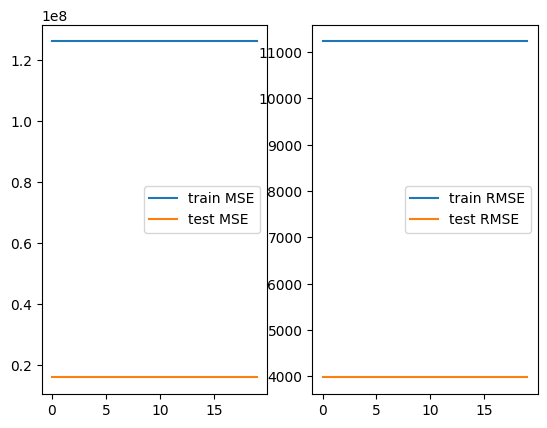

final MSE: 15829058.0
final RMSE: 3978.5748704781213
test MSE: 15829059.323529411
test RMSE: 3978.575036810216
log scaled test RMSE: 1.5962394018877015


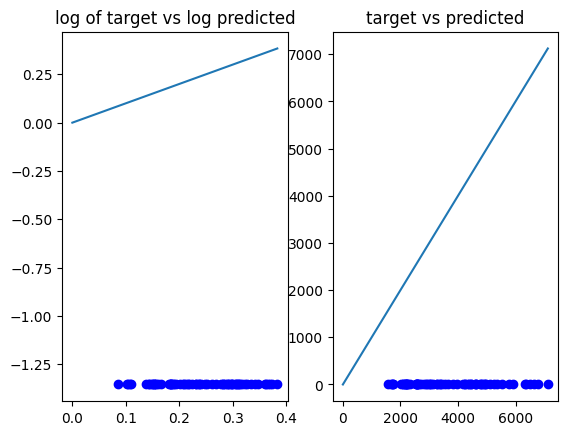

Model(
  (relu): ReLU()
  (layer_0): Linear(in_features=11, out_features=1, bias=True)
)

In [ ]:
parameters_dict = {
    'in_features' : X_train.shape[1],
    'out_features' : 1,
    'batch_size' : 2**3,
    'epochs' : 20,
    'scheduler':False,
    'learning_rate': 0.001,
    'layers_output_size': [1]

}
trainloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_train_scale,y_train),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])

testloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_test_scale,y_test),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])
model,test_rmse,final_results = train_model(trainloader, testloader, parameters_dict)
eval_target(final_results)

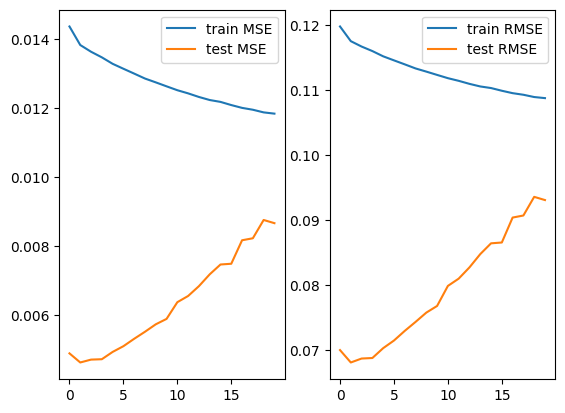

final MSE: 0.008667818270623684
final RMSE: 0.09310111852509445
test MSE: 0.008967302170008027
test RMSE: 0.09469584029939239
true (unscaled and unnormalized) test RMSE: 1751.1231457261863


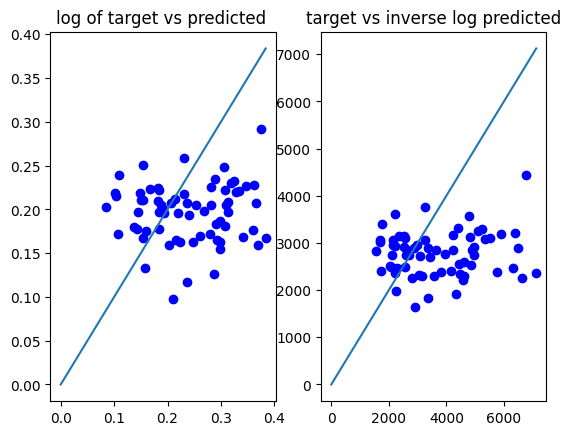

Model(
  (relu): ReLU()
  (layer_0): Linear(in_features=11, out_features=1, bias=True)
)

In [ ]:
parameters_dict = {
    'in_features' : X_train.shape[1],
    'out_features' : 1,
    'batch_size' : 2**3,
    'epochs' : 20,
    'scheduler':False,
    'learning_rate': 0.001,
    'layers_output_size': [1]

}
trainloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_train_scale,y_train_scaled),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])

testloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_test_scale,y_test_scaled),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])
model,test_rmse,final_results = train_model(trainloader, testloader, parameters_dict)
eval_log_target(final_results)

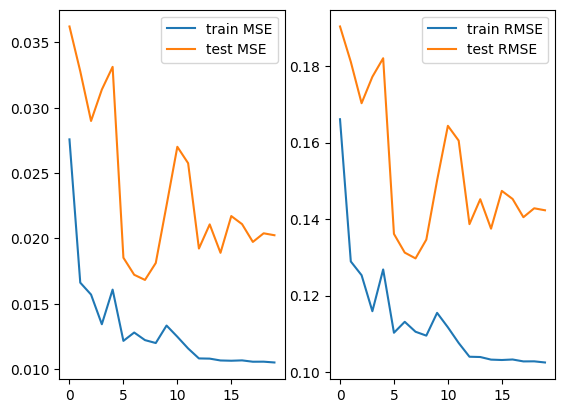

final MSE: 0.020247288048267365
final RMSE: 0.14229296556143373


In [ ]:
parameters_dict = {
    'in_features' : X_train.shape[1],
    'out_features' : 1,
    'batch_size' : 2**3,
    'epochs' : 20,
    'scheduler':True,
    'learning_rate': 0.1,
    'layers_output_size': [1]

}
trainloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_train_scale,y_train_scaled),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])

testloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_test_scale,y_test_scaled),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])
model = train_model(trainloader, testloader, parameters_dict)

In [ ]:
batch_sizes = [2**2, 2**3, 2**4, 2**6]
epoches = [10,15,20,25]
lr = [0.1,0.001,0.0001,0.00001]
layers = [[1],[5,1],[10,1],[10,5,1],[5,5,1],[10,10,10,1]]

In [ ]:
parameters_dict = {
    'in_features' : X_train.shape[1],
    'out_features' : 1,
    'batch_size' : 2**3,
    'epochs' : 20,
    'scheduler':False,
    'learning_rate': 0.1,
    'layers_output_size': [1]

}

creating functions to find best NN across set of hyperparameters

In [ ]:
def run_trials(parameter_dict, trial, items, y_type = 'log', weather = "weather"):
  if y_type == 'log':
    y_train_target = y_train_scaled
    y_test_target = y_test_scaled
  else:
    y_train_target = y_train
    y_test_target = y_test
  if weather == "weather":
    x_train = X_train_scale
    x_test = X_test_scale
  else:
    x_train = X_test_no_weather_norm_scale
    x_test = X_test_no_weather_norm_scale
  temp_dict =parameter_dict.copy()
  results = {}
  dicts = []
  if trial not in temp_dict.keys():
    print("bad key")
    return
  for x in items:
    temp_dict[trial] = x
    trainloader = torch.utils.data.DataLoader(pandas_to_pytorch(x_train,y_train_target),
                                          shuffle=True,
                                          batch_size=temp_dict['batch_size'])

    testloader = torch.utils.data.DataLoader(pandas_to_pytorch(x_test,y_test_target),
                                            shuffle=True,
                                            batch_size=temp_dict['batch_size'])
    print(temp_dict)
    model,test_rmse,final_results = train_model(trainloader, testloader, temp_dict, False)
    results[str(x)]=test_rmse
    dicts.append(temp_dict)
  return results,dicts

def plot_trial(results_dict,name):
  best = next(iter(results_dict))
  min = results_dict[best][-1]
  plt.title(name+ " trial")
  plt.xlabel('epoch')
  plt.ylabel('RMSE')
  color = plt.get_cmap('rainbow',len(results_dict))
  for i,x in enumerate(results_dict):
    plt.plot(range(len(results_dict[x])),results_dict[x], color=color(i), linewidth = 3,  label = x)
  # show a legend on the plot
    if results_dict[x][-1]<min:
      min = results_dict[x][-1]
      best = x
  plt.legend()
  plt.show()
  print("best trial: "+str(best))
  print("best RMSE: "+str(min))

{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.01989172026515007
final RMSE: 0.1410380100013825
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.001, 'layers_output_size': [1]}
final MSE: 0.050997424870729446
final RMSE: 0.22582609430871678
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.0001, 'layers_output_size': [1]}
final MSE: 0.06378249824047089
final RMSE: 0.2525519713652437
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 1e-05, 'layers_output_size': [1]}
final MSE: 0.06215658038854599
final RMSE: 0.2493122146797986


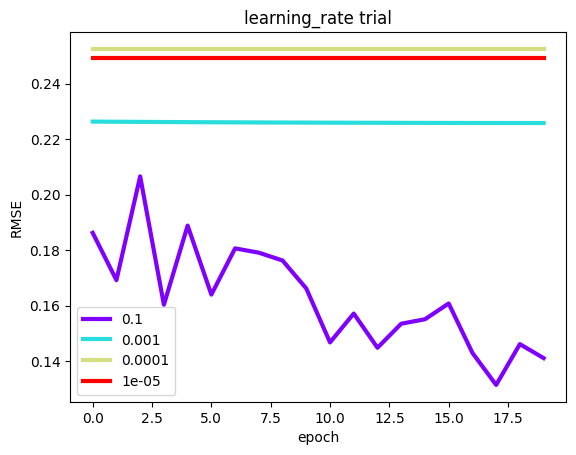

best trial: 0.1
best RMSE: 0.1410380100013825


In [ ]:
parameters_dict['scheduler'] = True
lr_trials,dicts = run_trials(parameters_dict, 'learning_rate', lr)
plot_trial(lr_trials, 'learning_rate')

{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': False, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.06378249078989029
final RMSE: 0.2525519566146544
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': False, 'learning_rate': 0.001, 'layers_output_size': [1]}
final MSE: 0.023500798270106316
final RMSE: 0.15329970081544947
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': False, 'learning_rate': 0.0001, 'layers_output_size': [1]}
final MSE: 0.057130735367536545
final RMSE: 0.23902036600996274
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': False, 'learning_rate': 1e-05, 'layers_output_size': [1]}
final MSE: 0.44421330094337463
final RMSE: 0.6664932864953514


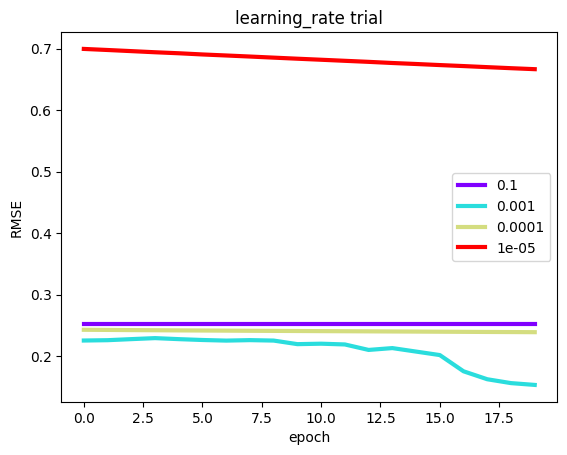

best trial: 0.001
best RMSE: 0.15329970081544947


In [ ]:
parameters_dict['scheduler'] = False
lr_trials,_ = run_trials(parameters_dict, 'learning_rate', lr)
plot_trial(lr_trials, 'learning_rate')

{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.022119225934147835
final RMSE: 0.1487253372299012
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.01971299573779106
final RMSE: 0.14040297624263903
{'in_features': 11, 'out_features': 1, 'batch_size': 16, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.021338369697332382
final RMSE: 0.1460765884641765
{'in_features': 11, 'out_features': 1, 'batch_size': 64, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.062442801892757416
final RMSE: 0.24988557760054383


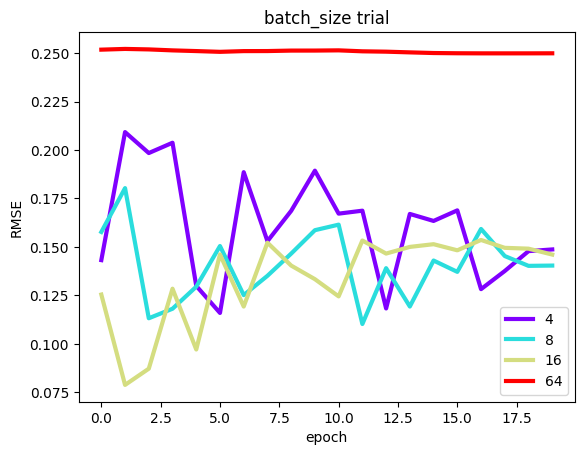

best trial: 8
best RMSE: 0.14040297624263903


In [ ]:
parameters_dict['scheduler'] = True
batch_trials,_ = run_trials(parameters_dict, 'batch_size', batch_sizes)
plot_trial(batch_trials, 'batch_size')

{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 10, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.017588568851351738
final RMSE: 0.13262190185392358
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 15, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.02402016520500183
final RMSE: 0.15498440310238262
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.021359926089644432
final RMSE: 0.1461503543945222
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 25, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.027027014642953873
final RMSE: 0.1643989496406649


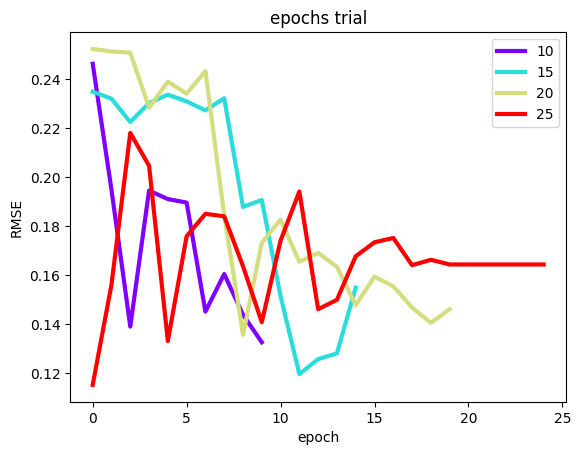

best trial: 10
best RMSE: 0.13262190185392358


In [ ]:
epoch_trials,_ = run_trials(parameters_dict, 'epochs', epoches)
plot_trial(epoch_trials, 'epochs')

{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.016596440225839615
final RMSE: 0.12882717192362647
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [5, 1]}
final MSE: 0.06378249078989029
final RMSE: 0.2525519566146544
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [10, 1]}
final MSE: 0.017428647726774216
final RMSE: 0.13201760385181294
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [10, 5, 1]}
final MSE: 0.011095155961811543
final RMSE: 0.10533354623201263
{'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [5, 5, 1]}
final MSE: 0.06378250569105148
final

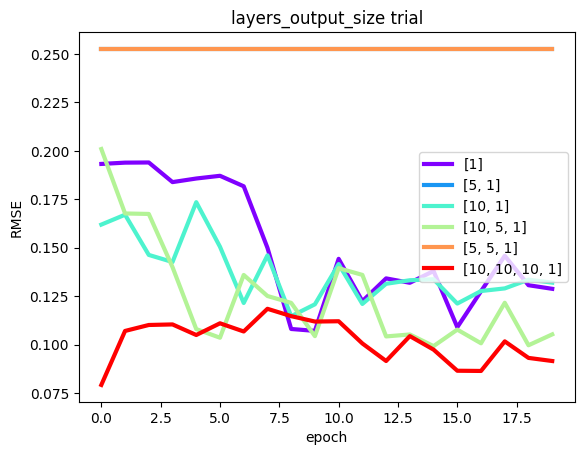

best trial: [10, 10, 10, 1]
best RMSE: 0.09158989724262495


In [ ]:
epoch_trials,_ = run_trials(parameters_dict, 'layers_output_size', layers)

plot_trial(epoch_trials, 'layers_output_size')

In [ ]:
epoch_trials

In [ ]:
#parameters to test together
batch_sizes = [2**2, 2**3, 2**4]
epoches = [10,20]
lr = [0.1,0.001]
layers = [[1],[10,5,1],[10,10,10,1]]
ls = [True,False]
#108 diff models.. luckily the data is tiny

In [ ]:
parameters_dict = {
    'in_features' : X_train.shape[1],
    'out_features' : 1,
    'batch_size' : 2**3,
    'epochs' : 20,
    'scheduler':True,
    'learning_rate': 0.1,
    'layers_output_size': [1]

}
torch.manual_seed(11)
trials = []
results = []
for b in batch_sizes:
  parameters_dict['batch_size']=b
  for e in epoches:
    parameters_dict['epochs']=e
    for l in lr:
      parameters_dict['learning_rate']=l
      for layer in layers:
        parameters_dict['layers_output_size']=layer
        tr, td = run_trials(parameters_dict, 'scheduler',ls,'log')
        results.extend([tr[x] for x in tr])
        trials.extend(td)
index_order = sorted(range(len(results)), key=lambda k: results[k][-1])


{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.01512353215366602
final RMSE: 0.12297777097372524
{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': False, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 0.023787006735801697
final RMSE: 0.15423036904514525
{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [10, 5, 1]}
final MSE: 0.06378249078989029
final RMSE: 0.2525519566146544
{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': False, 'learning_rate': 0.1, 'layers_output_size': [10, 5, 1]}
final MSE: 0.008058045990765095
final RMSE: 0.08976661957969173
{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [10, 10, 10, 1]}
final MSE: 0.0099790766835212

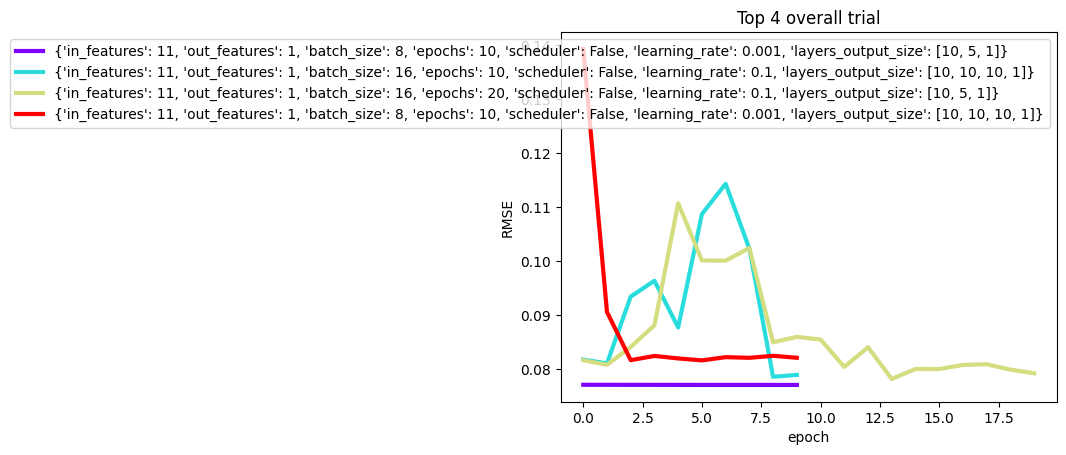

best trial: {'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 10, 'scheduler': False, 'learning_rate': 0.001, 'layers_output_size': [10, 5, 1]}
best RMSE: 0.0771004219568011


In [ ]:
best_4 = {}
for x in index_order[:5]:
  best_4[str(trials[x])]=results[x]
plot_trial(best_4, 'Top 4 overall')


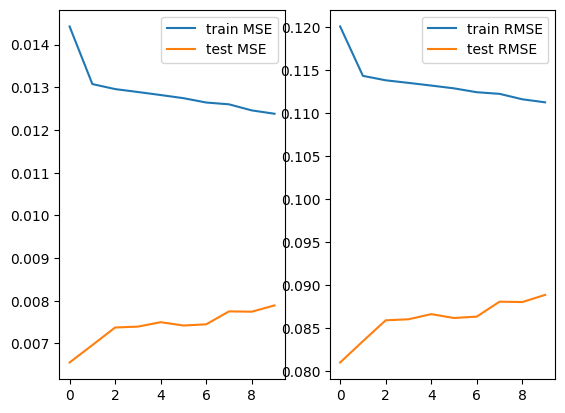

final MSE: 0.007891046814620495
final RMSE: 0.08883156429231952
test MSE: 0.008005398459071836
test RMSE: 0.08947289231421904
true (unscaled and unnormalized) test RMSE: 1726.8725492256954


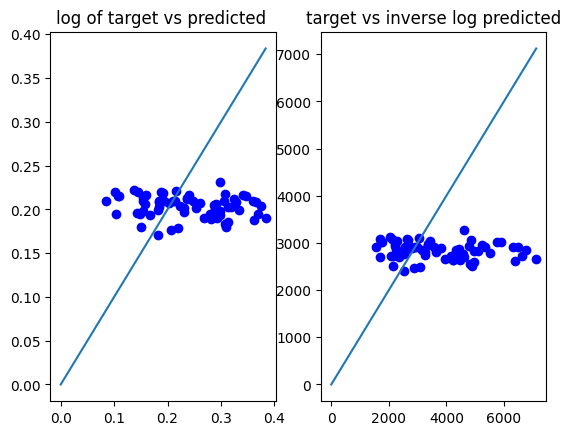

Model(
  (relu): ReLU()
  (layer_0): Linear(in_features=11, out_features=10, bias=True)
  (layer_1): Linear(in_features=10, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
parameters_dict = trials[index_order[0]]

trainloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_train_scale,y_train_scaled),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])

testloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_test_scale,y_test_scaled),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])

model,test_rmse,final_results = train_model(trainloader, testloader, parameters_dict,True)
eval_log_target(final_results)

{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 15798042.0
final RMSE: 3974.6750810600856
{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': False, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 15336958.0
final RMSE: 3916.2428423171104
{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [10, 5, 1]}
final MSE: 15829060.0
final RMSE: 3978.575121824395
{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': False, 'learning_rate': 0.1, 'layers_output_size': [10, 5, 1]}
final MSE: 8604046.0
final RMSE: 2933.265415880397
{'in_features': 11, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [10, 10, 10, 1]}
final MSE: 2787210.25
final RMSE: 1669.4940101719442
{'in_features': 11, 

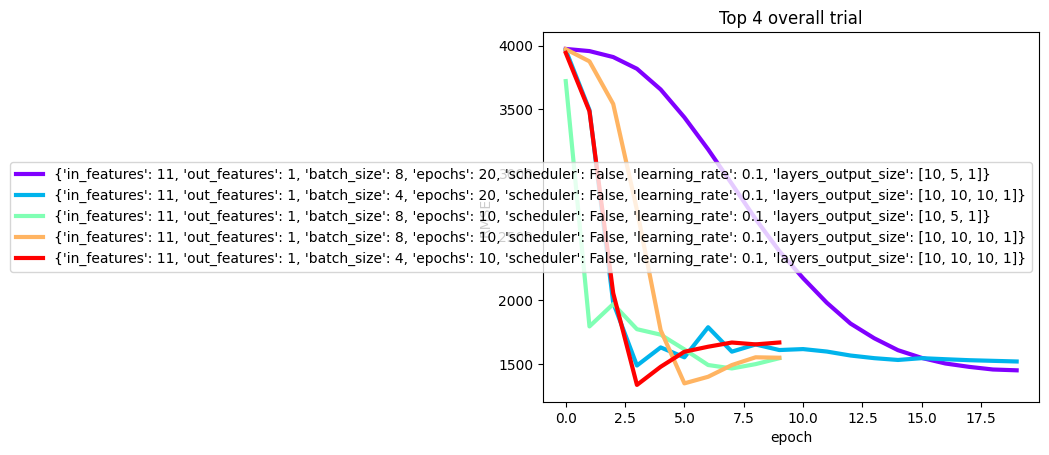

best trial: {'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': False, 'learning_rate': 0.1, 'layers_output_size': [10, 5, 1]}
best RMSE: 1451.036870654912


In [ ]:
parameters_dict = {
    'in_features' : X_train.shape[1],
    'out_features' : 1,
    'batch_size' : 2**3,
    'epochs' : 20,
    'scheduler':True,
    'learning_rate': 0.1,
    'layers_output_size': [1]

}
torch.manual_seed(11)
trials = []
results = []
for b in batch_sizes:
  parameters_dict['batch_size']=b
  for e in epoches:
    parameters_dict['epochs']=e
    for l in lr:
      parameters_dict['learning_rate']=l
      for layer in layers:
        parameters_dict['layers_output_size']=layer
        tr, td = run_trials(parameters_dict, 'scheduler',ls,'not_scaled')
        results.extend([tr[x] for x in tr])
        trials.extend(td)
index_order = sorted(range(len(results)), key=lambda k: results[k][-1])
best_4 = {}
for x in index_order[:5]:
  best_4[str(trials[x])]=results[x]
plot_trial(best_4, 'Top 4 overall')


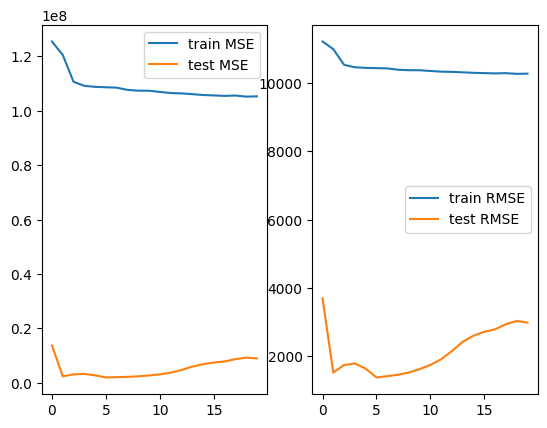

final MSE: 8940723.0
final RMSE: 2990.104178787087
test MSE: 7464675.344477361
test RMSE: 2732.155805307845
log scaled test RMSE: 0.3579581664890647


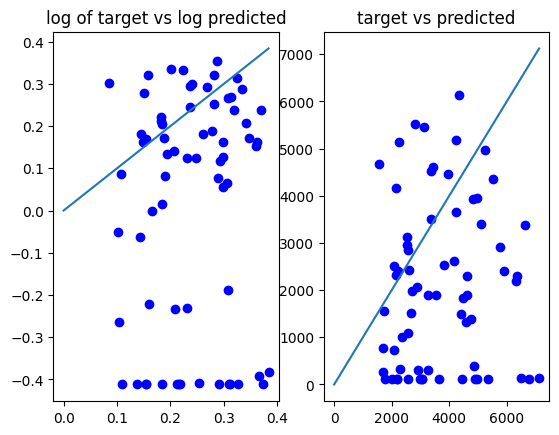

Model(
  (relu): ReLU()
  (layer_0): Linear(in_features=11, out_features=10, bias=True)
  (layer_1): Linear(in_features=10, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
parameters_dict = {'in_features': 11, 'out_features': 1, 'batch_size': 8, 'epochs': 20, 'scheduler': False, 'learning_rate': 0.1, 'layers_output_size': [10, 5, 1]}
trainloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_train_scale,y_train),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])

testloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_test_scale,y_test),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])

model,test_rmse,final_results = train_model(trainloader, testloader, parameters_dict,'not_log',True)
eval_target(final_results)

{'in_features': 5, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 15822035.0
final RMSE: 3977.6921700905914
{'in_features': 5, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': False, 'learning_rate': 0.1, 'layers_output_size': [1]}
final MSE: 15734280.0
final RMSE: 3966.645938321191
{'in_features': 5, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [10, 5, 1]}
final MSE: 15723296.0
final RMSE: 3965.2611515510553
{'in_features': 5, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': False, 'learning_rate': 0.1, 'layers_output_size': [10, 5, 1]}
final MSE: 15829060.0
final RMSE: 3978.575121824395
{'in_features': 5, 'out_features': 1, 'batch_size': 4, 'epochs': 10, 'scheduler': True, 'learning_rate': 0.1, 'layers_output_size': [10, 10, 10, 1]}
final MSE: 15094648.0
final RMSE: 3885.183135966695
{'in_features': 5, 'out_f

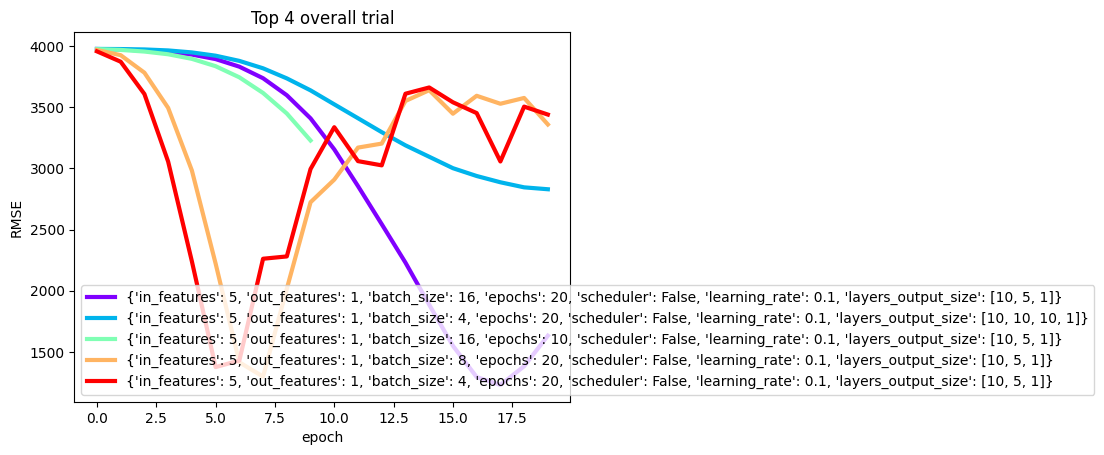

best trial: {'in_features': 5, 'out_features': 1, 'batch_size': 16, 'epochs': 20, 'scheduler': False, 'learning_rate': 0.1, 'layers_output_size': [10, 5, 1]}
best RMSE: 1632.0947429607143


In [ ]:
parameters_dict = {
    'in_features' : X_train_no_weather_norm_scale.shape[1],
    'out_features' : 1,
    'batch_size' : 2**3,
    'epochs' : 20,
    'scheduler':True,
    'learning_rate': 0.1,
    'layers_output_size': [1]

}
torch.manual_seed(11)
trials = []
results = []
for b in batch_sizes:
  parameters_dict['batch_size']=b
  for e in epoches:
    parameters_dict['epochs']=e
    for l in lr:
      parameters_dict['learning_rate']=l
      for layer in layers:
        parameters_dict['layers_output_size']=layer
        tr, td = run_trials(parameters_dict, 'scheduler',ls,'not_scaled', 'no_weather')
        results.extend([tr[x] for x in tr])
        trials.extend(td)
index_order = sorted(range(len(results)), key=lambda k: results[k][-1])
best_4 = {}
for x in index_order[:5]:
  best_4[str(trials[x])]=results[x]
plot_trial(best_4, 'Top 4 overall')


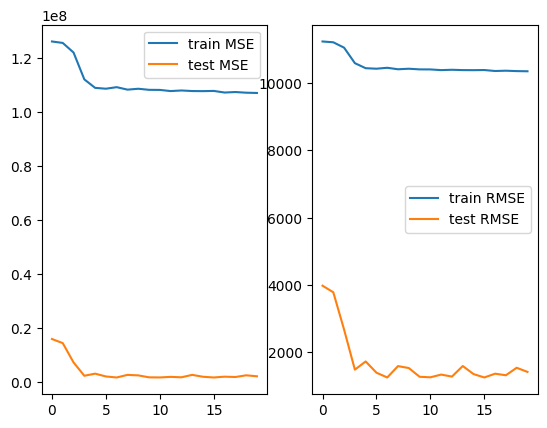

final MSE: 2007341.625
final RMSE: 1416.8068411043193
test MSE: 2867566.1007104637
test RMSE: 1693.388939585488
log scaled test RMSE: 0.09086334963224296


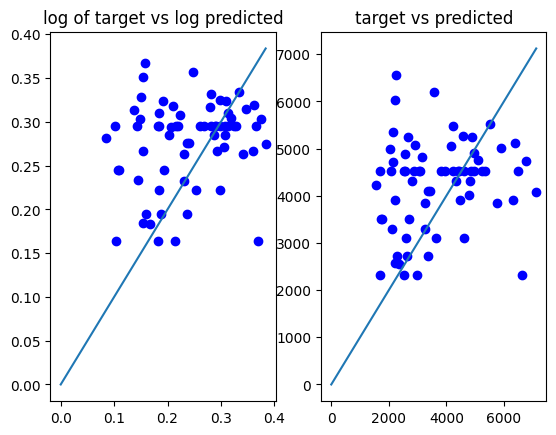

Model(
  (relu): ReLU()
  (layer_0): Linear(in_features=5, out_features=10, bias=True)
  (layer_1): Linear(in_features=10, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
parameters_dict = trials[index_order[0]]
parameters_dict['in_features']= X_train_no_weather_norm_scale.shape[1]
trainloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_train_no_weather_norm_scale,y_train),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])

testloader = torch.utils.data.DataLoader(pandas_to_pytorch(X_test_no_weather_norm_scale,y_test),
                                          shuffle=True,
                                          batch_size=parameters_dict['batch_size'])

model,test_rmse,final_results = train_model(trainloader, testloader, parameters_dict,True)
eval_target(final_results)

In [ ]:
!jupyter nbconvert --to pdf 'Colab Notebooks/Intro_to_AI_final.ipynb'

[NbConvertApp] Converting notebook Colab Notebooks/Intro_to_AI_final.ipynb to pdf
[NbConvertApp] Support files will be in Intro_to_AI_final_files/
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_to_AI_final_files
[NbConvertApp] Making directory ./Intro_t